<a href="https://colab.research.google.com/github/payalChandile21/10xTC/blob/main/Grounding_DINO_%26_SAM_to_Extract_Object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jan 28 11:56:57 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
import os
HOME = os.getcwd()
print(HOME)

/content/{HOME}/weights


In [8]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 463 (delta 176), reused 137 (delta 137), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/content/{HOME}/weights/GroundingDINO
  Preparing metadata (setup.py) ... done


In [9]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-e87n0rc0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-e87n0rc0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [5]:
!pip install torch

In [6]:
!pip install torchvision

In [1]:
!pip install supervision==0.12.0

In [10]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content/{HOME}/weights
/content/{HOME}/weights/weights


In [11]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [12]:
%cd {HOME}
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

/content/{HOME}/weights
cuda:0


In [18]:
GROUNDING_DINO_CONFIG_PATH = '/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
GROUNDING_DINO_CHECKPOINT_PATH = '/content/{HOME}/weights/groundingdino_swint_ogc.pth'

In [19]:
from groundingdino.util.inference import Model
GD_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)


final text_encoder_type: bert-base-uncased


/content/GroundingDINO/groundingdino/util/inference.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint_path, map_location="cpu")


In [20]:
import cv2
image_bgr = cv2.imread('/content/1.jpeg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_original = image_bgr

print(image_bgr.shape)

image_bgr = cv2.resize(image_bgr, (1024, 1024))
image_rgb = cv2.resize(image_rgb, (1024, 1024))
image_original = cv2.resize(image_original, (1024, 1024))

print(image_bgr.shape)



(264, 191, 3)
(1024, 1024, 3)


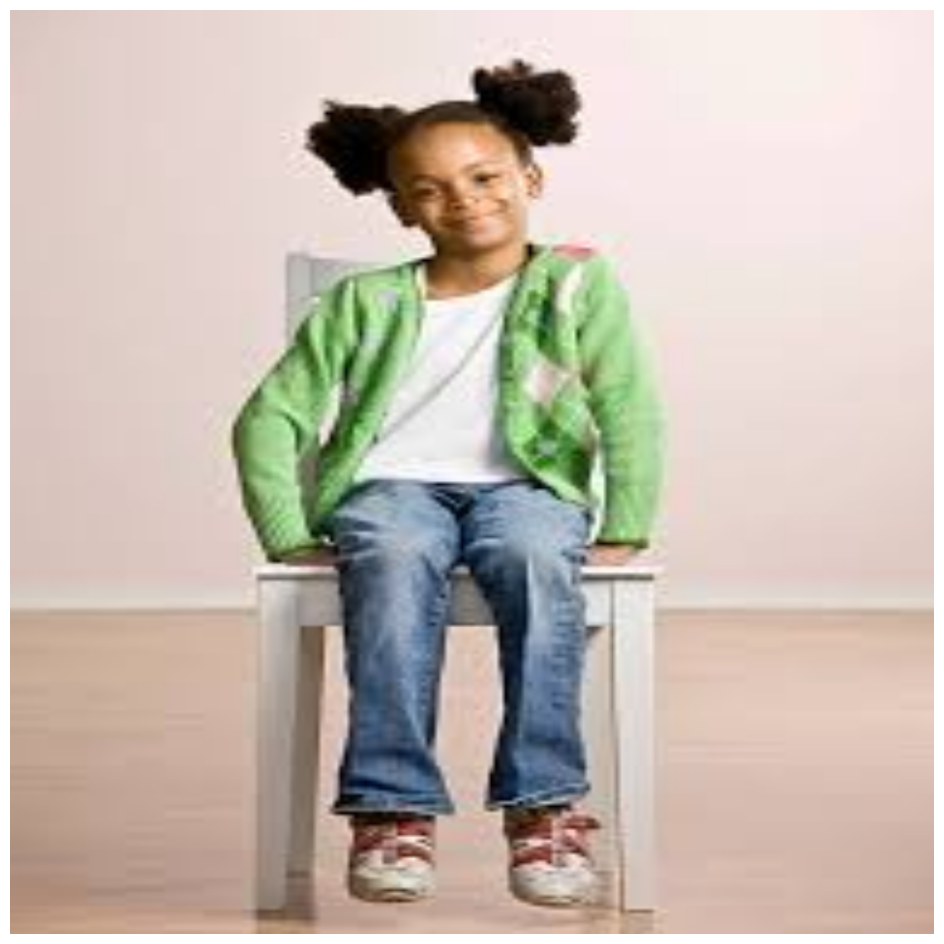

In [21]:
import supervision as sv
sv.plot_image(image_bgr)

In [22]:
# detect objects
CLASSES = ['person', 'chair']
detections = GD_model.predict_with_classes(
    image=image_rgb,
    classes=CLASSES,
    box_threshold=0.35,
    text_threshold=0.25
)

print(detections)

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Detections(xyxy=array([[ 243.12408,   51.48831,  729.5762 , 1001.5375 ],
       [ 265.1655 ,  261.27216,  720.9325 ,  999.11664]], dtype=float32), mask=None, confidence=array([0.6788259 , 0.35905758], dtype=float32), class_id=array([0, 1]), tracker_id=None)


/content/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [23]:
print(detections.xyxy, type(detections.xyxy))
detected_boxes = detections.xyxy
class_id = detections.class_id
print(class_id)

[[ 243.12408   51.48831  729.5762  1001.5375 ]
 [ 265.1655   261.27216  720.9325   999.11664]] <class 'numpy.ndarray'>
[0 1]


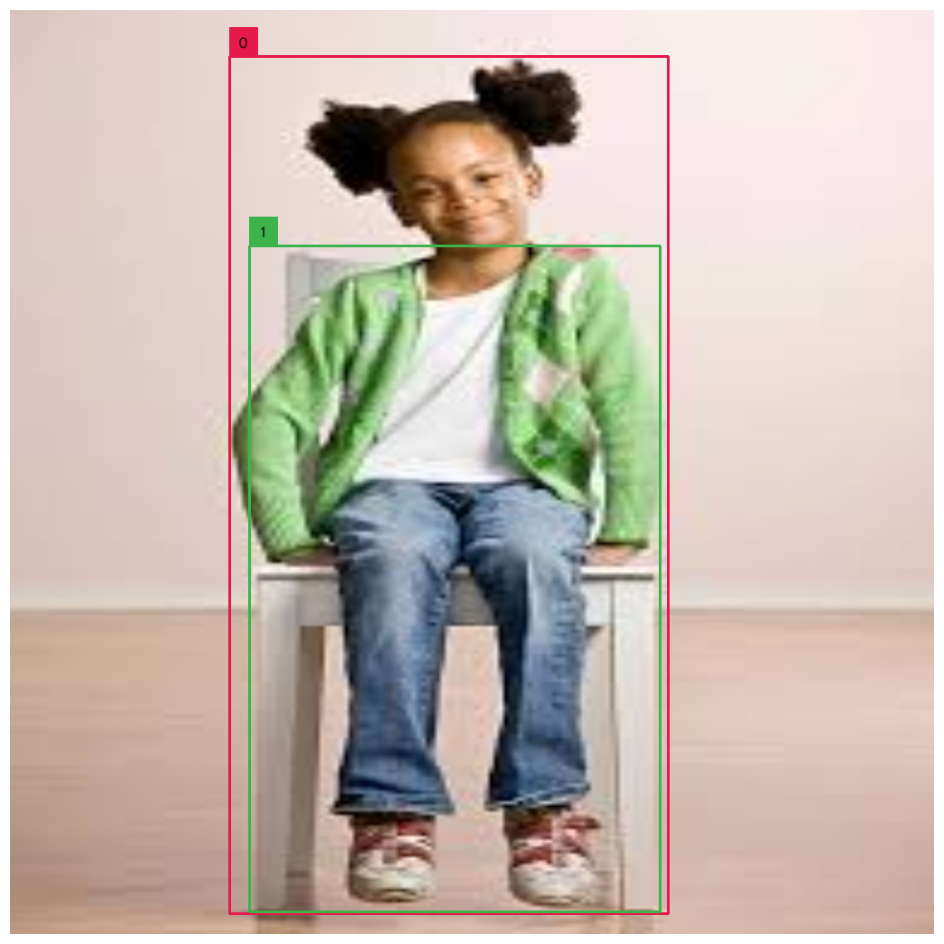

In [24]:
import supervision as sv
box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=False, labels=[class_id])
sv.plot_image(annotated_frame)


In [26]:
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = '/content/{HOME}/weights/sam_vit_h_4b8939.pth'

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_predictor = SamPredictor(sam)


/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [27]:
import numpy as np
mask_annotator =  sv.MaskAnnotator(color=sv.Color.blue())
segmented_mask = []
counter = 0
for mybox in detected_boxes:
    mybox = np.array(mybox)
    print(mybox)


    mask_predictor.set_image(image_rgb)
    masks, scores, logits = mask_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=mybox,
        multimask_output=False
    )

    segmented_mask.append(masks)
    print(len(masks), masks.shape)

# plot mask on image using supervision
    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks),
        mask=masks
    )

    detections = detections[detections.area == np.max(detections.area)]
    print(CLASSES[class_id[counter]])

    annotated_image = box_annotator.annotate(scene=image_original.copy(), detections=detections, skip_label=False, labels=[CLASSES[class_id[counter]]])
    annotated_image = mask_annotator.annotate(scene=annotated_image.copy(), detections=detections)
    image_original = annotated_image

    counter+=1

[ 243.12408   51.48831  729.5762  1001.5375 ]
1 (1, 1024, 1024)
person
[265.1655  261.27216 720.9325  999.11664]
1 (1, 1024, 1024)
chair


Plot image using Supervion

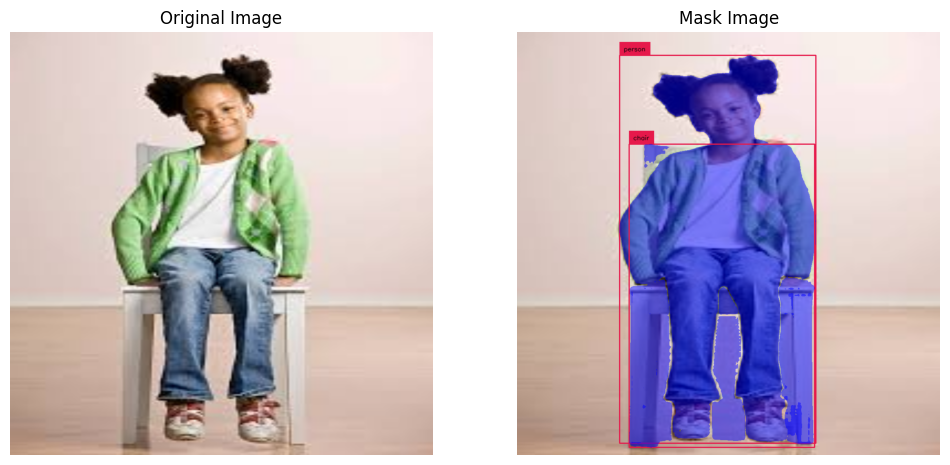

In [28]:
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1,2),
    titles=['Original Image', 'Mask Image']

)


In [29]:
print(len(segmented_mask), type(segmented_mask[0]), segmented_mask[0].shape)

for i in range(len(segmented_mask)):

  segmented_mask[i] = segmented_mask[i].transpose(1,2,0)
  segmented_mask[i] = np.array(segmented_mask[i]*255).astype('uint8')
  segmented_mask[i]  = cv2.cvtColor(segmented_mask[i] , cv2.COLOR_GRAY2BGR)


print(segmented_mask[0].shape)

2 <class 'numpy.ndarray'> (1, 1024, 1024)
(1024, 1024, 3)


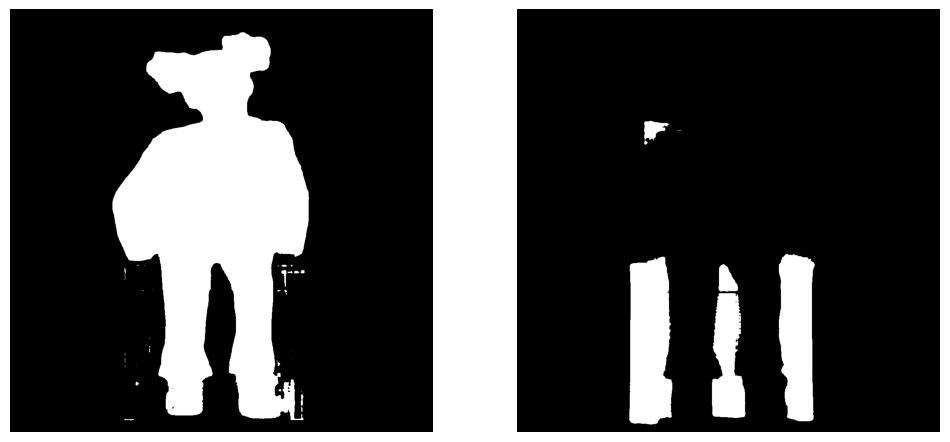

In [30]:
sv.plot_images_grid(
    images=segmented_mask,
    grid_size=(1, len(segmented_mask)),

)

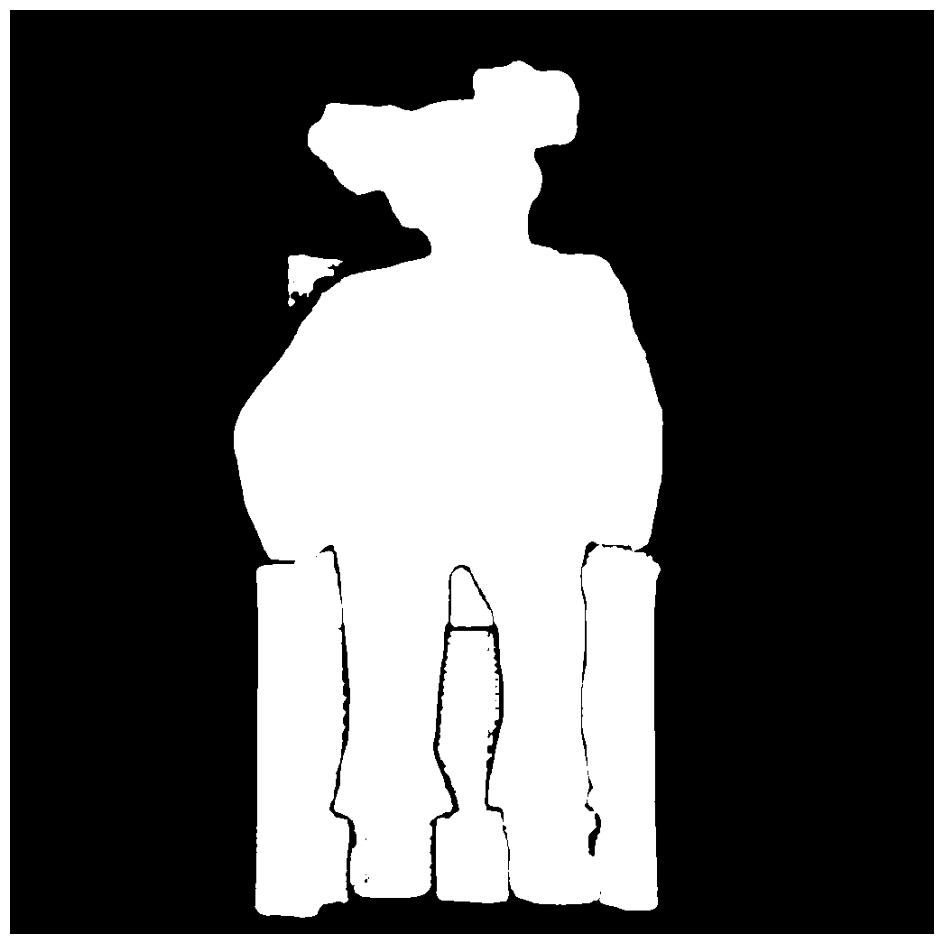

In [31]:
segmented_image = segmented_mask[0]

for i in range(len(segmented_mask)):
  try:
    segmented_image = cv2.bitwise_or(segmented_image, segmented_mask[i+1])
  except:
    pass

sv.plot_image(segmented_image)

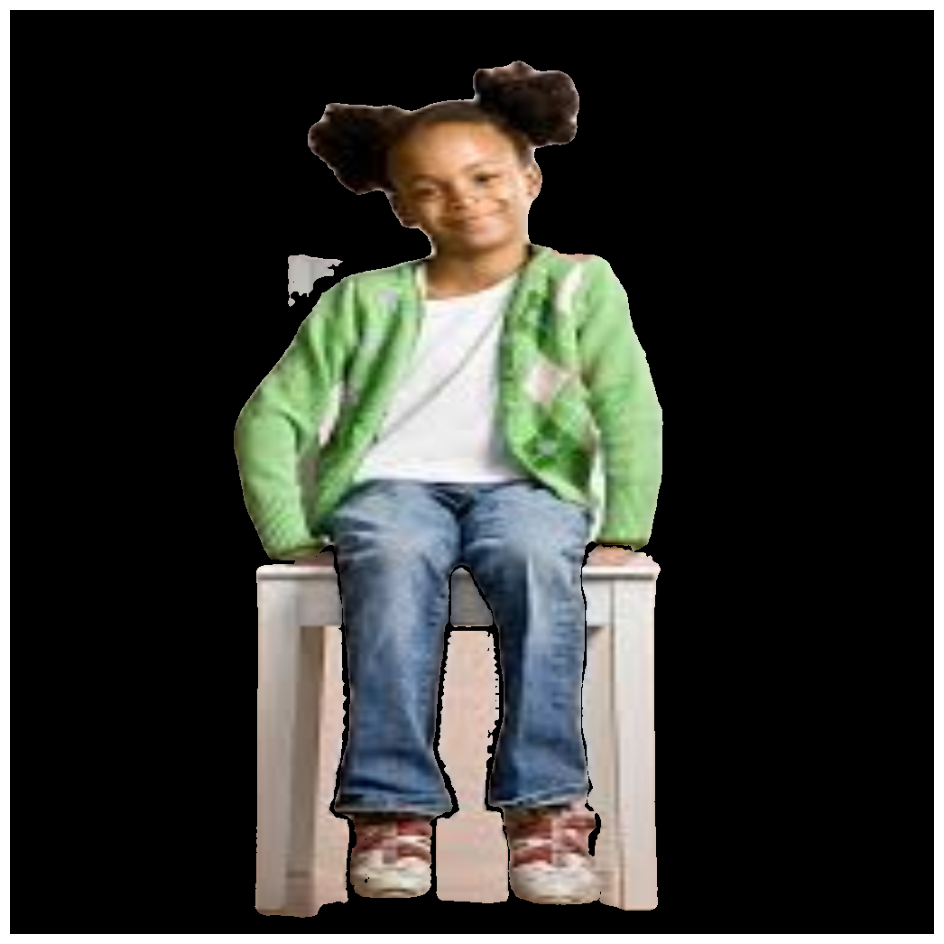

In [32]:
segmented_image = cv2.bitwise_and(segmented_image, image_bgr)
sv.plot_image(segmented_image)

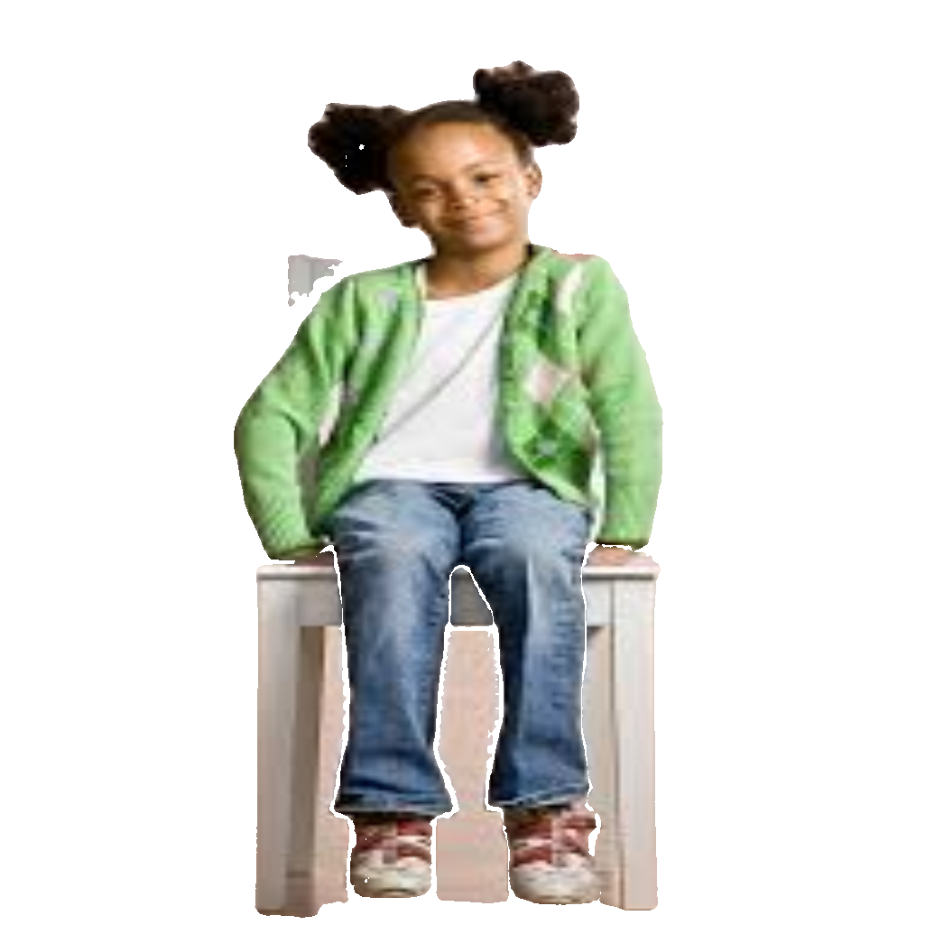

In [33]:
segmented_image[np.where((segmented_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
sv.plot_image(segmented_image)

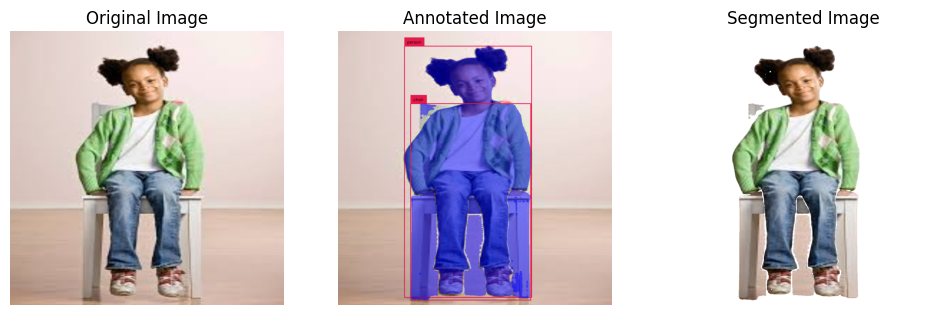

In [34]:
sv.plot_images_grid(
    images=[image_bgr, annotated_image, segmented_image],
    grid_size=(1, 3),
    titles=['Original Image', 'Annotated Image', 'Segmented Image'],
    #size=(48,48)

)